In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

plt.style.use('seaborn')

In [2]:
PATH = 'chest_xray/train'
im_path = {'n':[],
           'p':[]}
for i in os.listdir(PATH):
    for j in os.listdir(os.path.join(PATH, i)):
        if i == 'PNEUMONIA':
            im_path['p'].append(os.path.join(PATH,i,j))
        elif i == 'NORMAL':
            im_path['n'].append(os.path.join(PATH,i,j))

In [3]:
sizes=[]
for l in ['p','n']:
    for i in im_path[l]:
        sizes.append(Image.open(i).size)
sizes = np.array(sizes)

In [4]:
np.mean(sizes, axis=0)/1.5

array([794.88663088, 550.66871166])

In [5]:
PATH = './chest_xray'
data_transforms = {
    'train':transforms.Compose([
        #transforms.RandomCrop((500,800), pad_if_needed=True, padding_mode='reflect'),
        transforms.Resize((500,800)),
        #transforms.Pad((800,500), padding_mode='reflect')
        #transforms.CenterCrop((500,800)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()]),
    'val':transforms.Compose([
        #transforms.RandomCrop((400,600), pad_if_needed=True, padding_mode='reflect'),
        transforms.Resize((500,800)),
        #transforms.Pad((800,500), padding_mode='reflect')
        #transforms.CenterCrop((500,800)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()])
}
image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

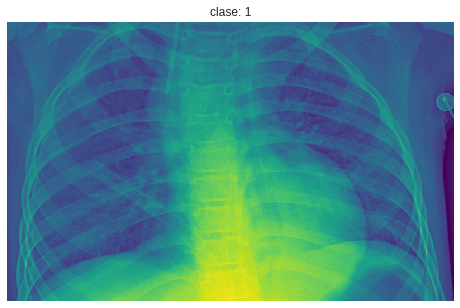

In [10]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
plt.imshow(inputs.numpy()[0,0], cmap='viridis')
plt.title(f'clase: {classes.numpy()[0]}');
plt.axis('off');

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
vgg16 = torchvision.models.vgg16(pretrained=True)

In [13]:
for param in vgg16.parameters():
    param.requires_grad = False

In [14]:
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [21]:
vgg16.load_state_dict(torch.load('vgg16_1.pt'))

<All keys matched successfully>

In [22]:
vgg = vgg16.to(device)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.001)

In [59]:
n_epochs = 1

train_loss, eval_loss = [],[]
for epoch in range(n_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            vgg16.train()
        else:
            vgg16.eval()
            
        for inputs, labels in tqdm(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = vgg16(inputs)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    train_loss.append(loss.detach().to('cpu').numpy())
                else:
                    eval_loss.append(loss.to('cpu').numpy())

100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


In [60]:
t_loss = np.array(train_loss)
e_loss = np.array(eval_loss)

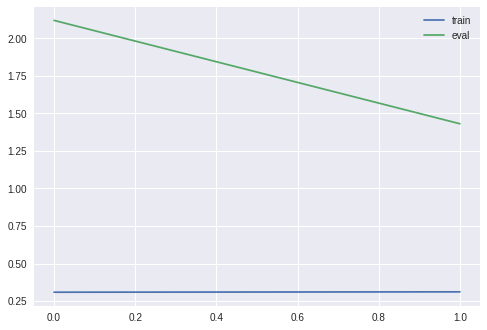

In [61]:
plt.plot(np.mean(t_loss.reshape(-1,len(t_loss)//len(e_loss)),axis=1), label='train')
plt.plot(e_loss, label='eval')
plt.legend()

In [23]:
vgg16.eval()
aciertos = []
random = []
for inputs, labels in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    outputs = vgg16(inputs)
    _, preds = torch.max(outputs, 1)
    aciertos.append([i==j for i, j in zip(preds.to('cpu').numpy(),labels.numpy())])
    random.append([np.random.randint(0,2)==j for j in labels.numpy()])
random = np.array(random).reshape(-1)
aciertos = np.array(aciertos).reshape(-1)

100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


In [24]:
print(f'Random accuracy: {np.sum(random)/len(random)}')
print(f'VGG16 accuracy: {np.sum(aciertos)/len(aciertos)}')

Random accuracy: 0.5
VGG16 accuracy: 0.5625


In [64]:
torch.save(vgg16.state_dict(), 'vgg16_1.pt')